In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re
from matplotlib import colormaps  
from aind_analysis_arch_result_access.han_pipeline import get_mle_model_fitting
from scipy.stats import linregress
from typing import Sequence



In [2]:
#Load kinematics data
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
    load_keypoints_from_csv,
    find_behavior_videos_folder,
    integrate_keypoints_with_video_time,
    get_session_name_from_path
)

#keypoints
LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv'
LP_csv_path = '/root/capsule/data/behavior_751004_2024-12-23_14-19-57_processed_2025-07-10_06-34-56/pred_outputs/video_preds/bottom_camera_predictions.csv'
keypoint_dfs = load_keypoints_from_csv(LP_csv_path)


# session_name = os.path.basename(os.path.dirname(LP_csv_path))

session_name = get_session_name_from_path(LP_csv_path)
print(f"Session name detected: {session_name}")

behavior_videos_folder = find_behavior_videos_folder(f'/root/capsule/data/{session_name}')

#get video timebase for keypoint dataframe
keypoint_dfs_trimmed, video_csv_trimmed = integrate_keypoints_with_video_time(
    os.path.join(behavior_videos_folder, 'bottom_camera.csv'), 
    keypoint_dfs
)

keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Session name detected: behavior_751004_2024-12-23_14-19-57
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 3338382 to 3338381


In [3]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
    mask_keypoint_data, kinematics_filter, segment_movements_trimnans
)

#tongue kinematics processing and movement segmentation
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip_center',confidence_threshold=0.90)
tongue_filtered = kinematics_filter(tongue_masked,cutoff_freq=50,filter_order=4,filter_kind='cubic')
tongue_segmented = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)

#tongue_segmented is a frame-level tidy datafram with tongue kinematics and movements segmented by 'movement_id'


In [4]:
#connect to nwb dfs
from aind_dynamic_foraging_behavior_video_analysis.kinematics.kinematics_nwb_utils import get_nwb_file
import aind_dynamic_foraging_data_utils.nwb_utils as nwb_utils
from aind_dynamic_foraging_basic_analysis.licks import annotation

nwb = get_nwb_file(session_name)
nwb.df_events = nwb_utils.create_events_df(nwb)
nwb.df_trials = nwb_utils.create_df_trials(nwb)
nwb.df_licks = annotation.annotate_licks(nwb)

NWB file not found for 751004 on 2024-12-23. Generating it now...
Generated NWB file: /root/capsule/scratch/behavior_751004_2024-12-23_14-19-57/751004_2024-12-23_14-20-03.nwb
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:506: UserWarning: Reward before choice time.                 This is likely due to manual rewards not being recorded in sessions from 2024
  warnings.warn("Reward before choice time. \


In [5]:
#annotate trial info, lick info, and make movement-level dataframe

from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
    annotate_trials_in_kinematics, annotate_licks_in_kinematics, assign_movements_to_licks,
    aggregate_tongue_movements, add_lick_metadata_to_movements
)

tongue_annotated = annotate_trials_in_kinematics(tongue_segmented, nwb.df_trials)
tongue_kinematics = annotate_licks_in_kinematics(tongue_annotated, nwb.df_licks, tolerance=0.01)
nwb.df_licks = assign_movements_to_licks(tongue_kinematics, nwb.df_licks)
# tongue_kinematics is same as tongue_segmented df (tidy frame-level df) with addition of annotations of trials and licks


tongue_movements = aggregate_tongue_movements(tongue_kinematics,keypoint_dfs_trimmed)

tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    nwb.df_licks,
    fields=['cue_response', 'rewarded', 'event']
)
#tongue_movements is an aggregated tidy dataframe of movements (rows) by feature/parameter (eg peak_velocity, rewarded, etc)

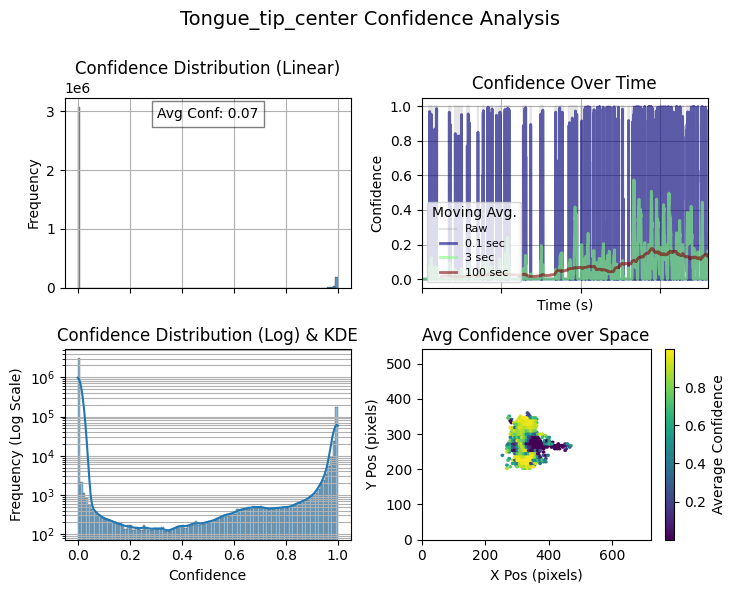

In [6]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import plot_keypoint_confidence_analysis, plot_basic_kinematics_movement_segment

plot_keypoint_confidence_analysis(keypoint_dfs_trimmed,'tongue_tip_center')

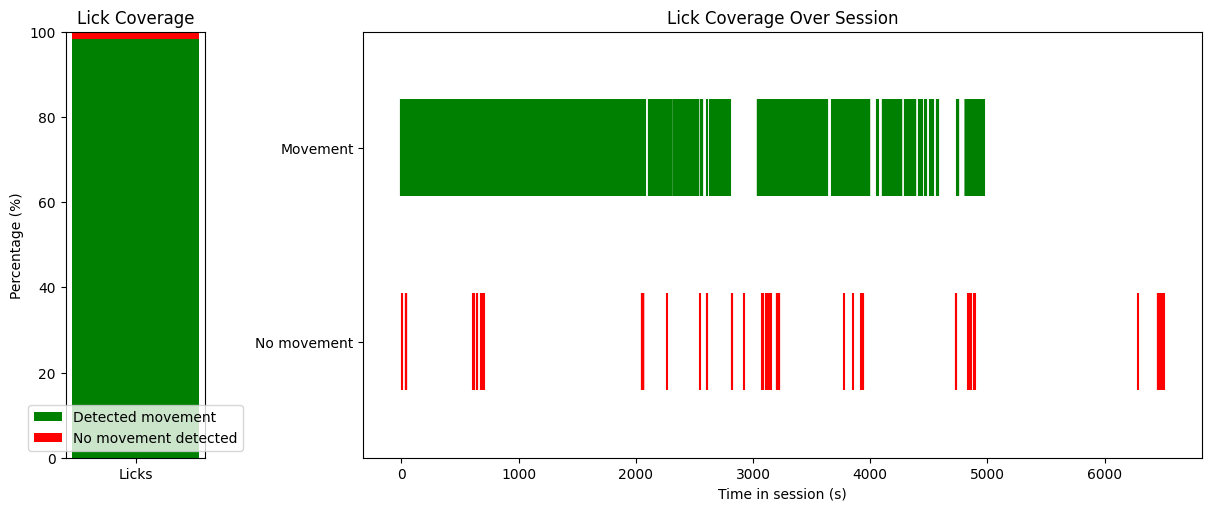

In [7]:
import matplotlib.pyplot as plt

# Compute stats
licks_total = len(nwb.df_licks)
licks_with_movements = nwb.df_licks['nearest_movement_id'].notna().sum()
licks_without_movements = licks_total - licks_with_movements

coverage_pct = (licks_with_movements / licks_total) * 100
no_coverage_pct = 100 - coverage_pct

licks = nwb.df_licks

# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[1, 6], constrained_layout=True)

# Subplot 1: Stacked bar chart
ax1.bar(['Licks'], [coverage_pct], label='Detected movement', color='green')
ax1.bar(['Licks'], [no_coverage_pct], bottom=[coverage_pct], label='No movement detected', color='red')

ax1.set_ylabel('Percentage (%)')
ax1.set_title('Lick Coverage')
ax1.legend(loc='lower center')
ax1.set_ylim(0, 100)

# Subplot 2: Event plot of lick timings
ax2.eventplot(
    [licks[licks['nearest_movement_id'].notna()]['timestamps'],
     licks[licks['nearest_movement_id'].isna()]['timestamps']],
    colors=['green', 'red'],
    lineoffsets=[1, 0],
    linelengths=[0.5]
)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['No movement', 'Movement'])
ax2.set_xlabel('Time in session (s)')
ax2.set_title('Lick Coverage Over Session')

plt.show()


In [10]:
tongue_movements.columns

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'time_to_endpoint',
       'excursion_angle_deg', 'max_x_from_jaw', 'max_x_from_jaw_y',
       'max_y_from_jaw', 'max_y_from_jaw_x', 'max_x_distance',
       'max_y_distance', 'n_datapoints_x', 'dropped_frames_n_x',
       'dropped_frames_pct_x', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event', 'n_datapoints_y',
       'dropped_frames_n_y', 'dropped_frames_pct_y'],
      dtype='object')

KeyError: 'n_datapoints'

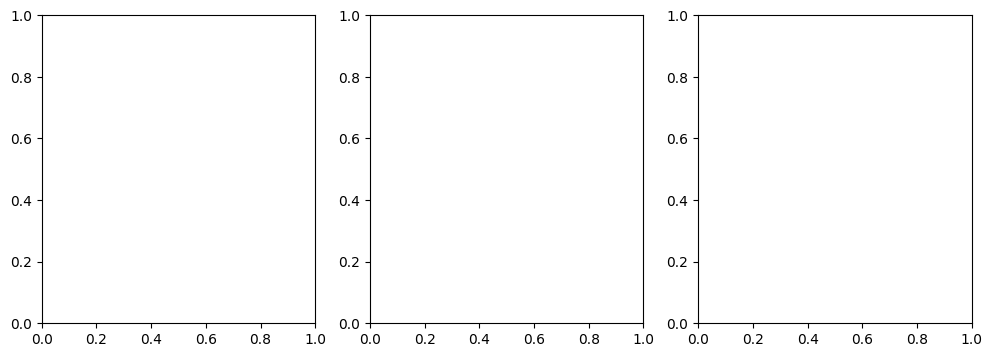

In [9]:
lick_movements = tongue_movements[tongue_movements['has_lick']]


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(lick_movements['n_datapoints'], bins=30, color='skyblue')
axes[0].set_title('Frames per Lick Movement')

axes[1].hist(lick_movements['duration'], bins=30, color='lightgreen')
axes[1].set_title('Movement Duration (s)')

axes[2].hist(lick_movements['dropped_frames_pct'], bins=30, color='salmon')
axes[2].set_title('Dropped Frames (%)')

for ax in axes:
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

plt.suptitle('Lick-Associated Movement Quality')
plt.tight_layout()
plt.show()


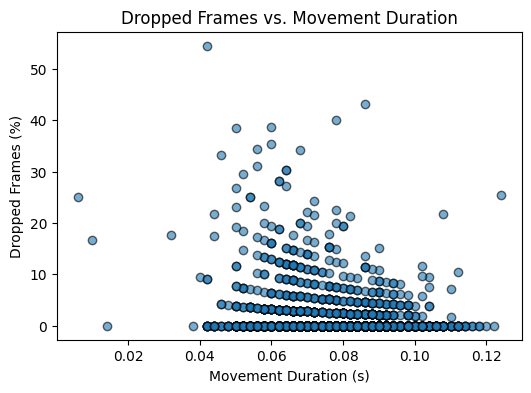

In [ ]:
fig, axes = plt.subplots(figsize=(6, 4))

plt.scatter(lick_movements['duration'], lick_movements['dropped_frames_pct'],
            alpha=0.6, edgecolor='k')
plt.xlabel('Movement Duration (s)')
plt.ylabel('Dropped Frames (%)')
plt.title('Dropped Frames vs. Movement Duration')

plt.show()


In [ ]:
tongue_movs = tongue_movements

# Coverage statistic
total_licks = len(nwb.df_licks)
with_mov = nwb.df_licks['nearest_movement_id'].notna().sum()
coverage_pct = 100 * with_mov / total_licks

# Quality metrics from aggregated frame stats in tongue_movs
lick_movs = tongue_movs[tongue_movs['has_lick']]
quality = {
    'mean_n_datapoints':    lick_movs['n_datapoints'].mean(),
    'mean_duration_s':      lick_movs['duration'].mean(),
    'mean_dropped_pct':     lick_movs['dropped_frames_pct'].mean(),
}

# Create and save summary figure with coverage, scatter, and histograms
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
gs = fig.add_gridspec(2, 3)

# Top row: coverage bar (span 2 cols) and scatter
ax_cov = fig.add_subplot(gs[0, :2])
ax_scatter = fig.add_subplot(gs[0, 2])

ax_cov.bar(['covered', 'missed'], [coverage_pct, 100-coverage_pct], color=['green','red'])
ax_cov.set_ylim(0, 100)
ax_cov.set_title(f"{session_id}\nLick Coverage (%)")

ax_scatter.scatter(lick_movs['duration'], lick_movs['dropped_frames_pct'], alpha=0.6, edgecolor='k')
ax_scatter.set_xlabel('Duration (s)')
ax_scatter.set_ylabel('Dropped frames (%)')
ax_scatter.set_title('Quality: duration vs drop%')

# Bottom row: three histograms
ax0 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[1, 1])
ax2 = fig.add_subplot(gs[1, 2])

ax0.hist(lick_movs['n_datapoints'], bins=30)
ax0.set_title('Frames per Lick Movement')
ax0.set_xlabel('n_datapoints')
ax0.set_ylabel('Count')

ax1.hist(lick_movs['duration'], bins=30)
ax1.set_title('Movement Duration (s)')
ax1.set_xlabel('duration')
ax1.set_ylabel('Count')

ax2.hist(lick_movs['dropped_frames_pct'], bins=30)
ax2.set_title('Dropped Frames (%)')
ax2.set_xlabel('dropped_frames_pct')
ax2.set_ylabel('Count')

out_png = scratch_dir / f"{session_id}_summary.png"
fig.savefig(out_png, dpi=150)
plt.close(fig)

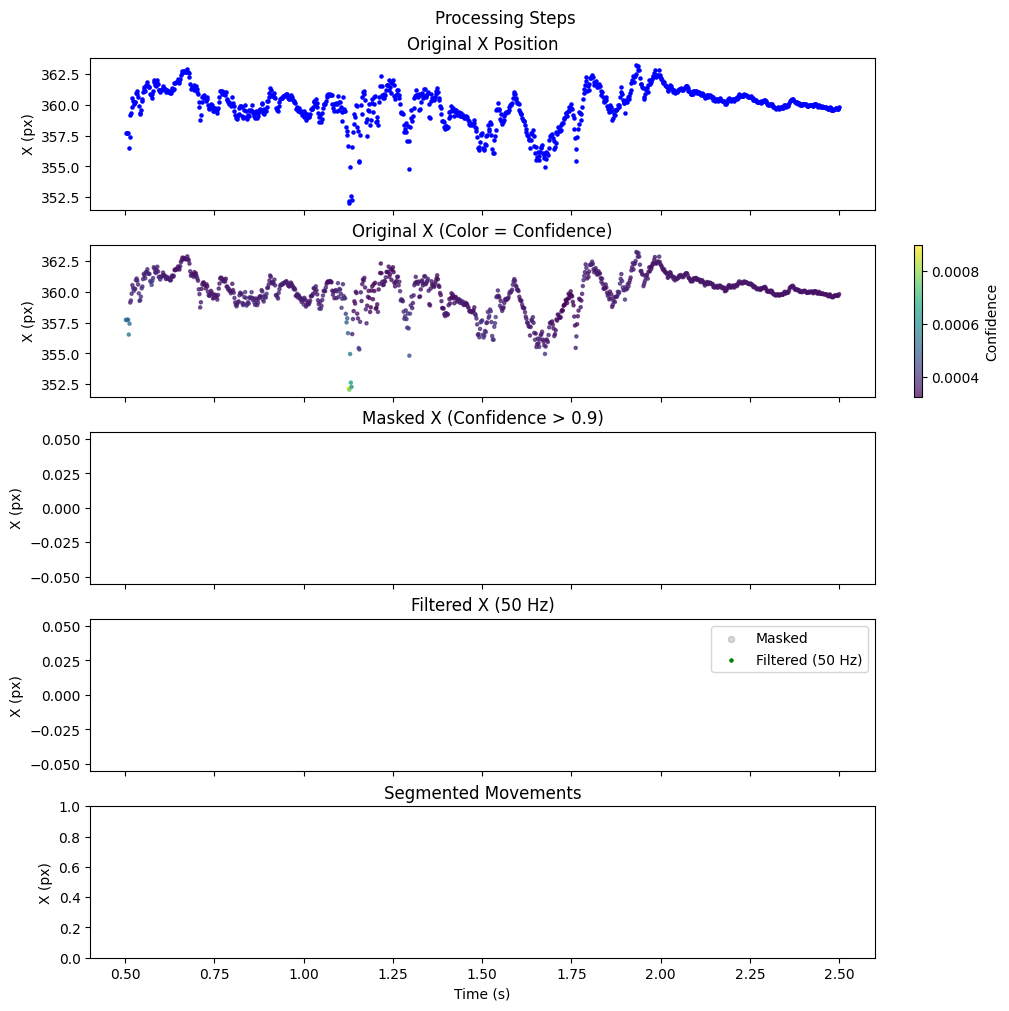

In [26]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import plot_filtering_steps, plot_processing_steps

save_dir = ''
save_figures = False


#plot tongue from first trial with >n licks (from lickometer)
n = 5
lick_counts = nwb.df_licks.groupby("trial").size()
first_trial = lick_counts[lick_counts > n].index.min()

trial_start = nwb.df_trials.loc[nwb.df_trials['trial'] == first_trial, 'goCue_start_time_in_session'].iloc[0]
#probably makes sense to align these plots to a trial, depending on kinematic point of interest
plot_processing_steps(keypoint_dfs_trimmed, tongue_filtered, tongue_masked, tongue_segmented,
                      start_time=trial_start+.5, end_time=trial_start+2.5, save_dir=save_dir, save_figures=save_figures)


In [27]:
nwb.df_licks

,timestamps,data,event,raw_timestamps,trial,pre_ili,post_ili,bout_start,bout_end,bout_number,...,cue_response,bout_cue_response,intertrial_choice,bout_intertrial_choice,cue_switch,iti_switch,bout_cue_switch,bout_iti_switch,within_session,nearest_movement_id
0,0.444896,1.0,right_lick_time,268103.340096,0,NaN,0.157344,True,False,1,...,True,True,False,False,False,False,False,False,True,121
1,0.602240,1.0,right_lick_time,268103.497440,0,0.157344,0.178240,False,False,1,...,False,True,False,False,False,False,False,False,True,122
2,0.780480,1.0,right_lick_time,268103.675680,0,0.178240,0.128320,False,False,1,...,False,True,False,False,False,False,False,False,True,123
3,0.908800,1.0,right_lick_time,268103.804000,0,0.128320,0.168640,False,False,1,...,False,True,False,False,False,False,False,False,True,124
4,1.077440,1.0,right_lick_time,268103.972640,0,0.168640,0.198624,False,False,1,...,False,True,False,False,False,False,False,False,True,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5392,6486.622528,1.0,left_lick_time,274589.517728,578,0.536192,1.756384,False,True,839,...,False,False,False,True,False,False,False,False,False,<NA>
5393,6488.378912,1.0,left_lick_time,274591.274112,578,1.756384,0.966016,True,True,840,...,False,False,True,True,False,False,False,False,False,<NA>
5394,6489.344928,1.0,left_lick_time,274592.240128,578,0.966016,6.100928,True,True,841,...,False,False,True,True,False,False,False,False,False,<NA>
5395,6495.445856,1.0,left_lick_time,274598.341056,578,6.100928,6.807616,True,True,842,...,False,False,True,True,False,False,False,False,False,<NA>


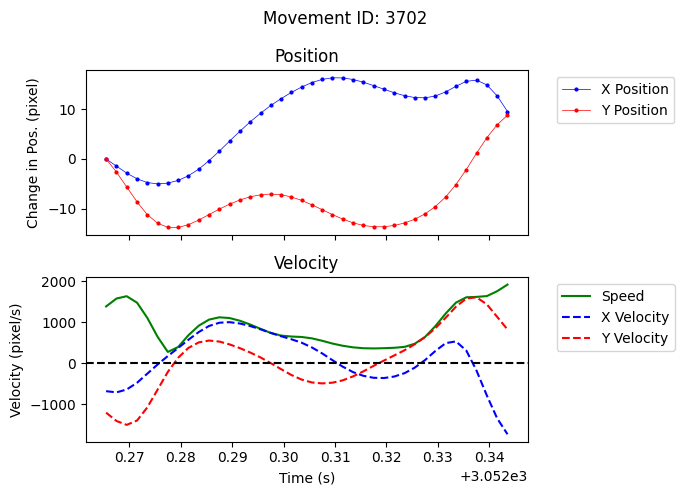

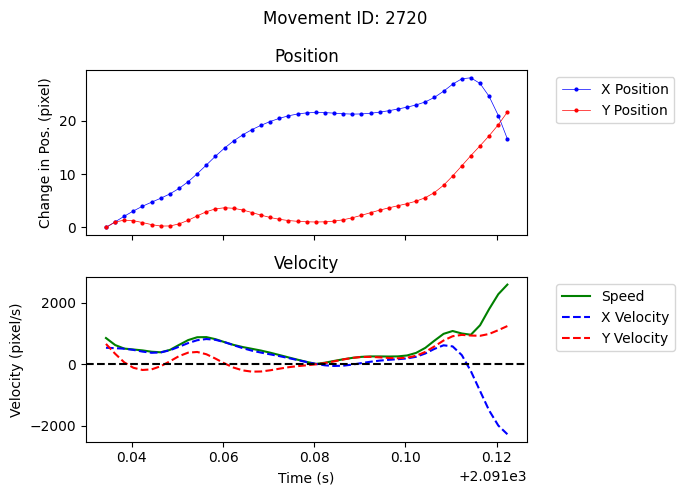

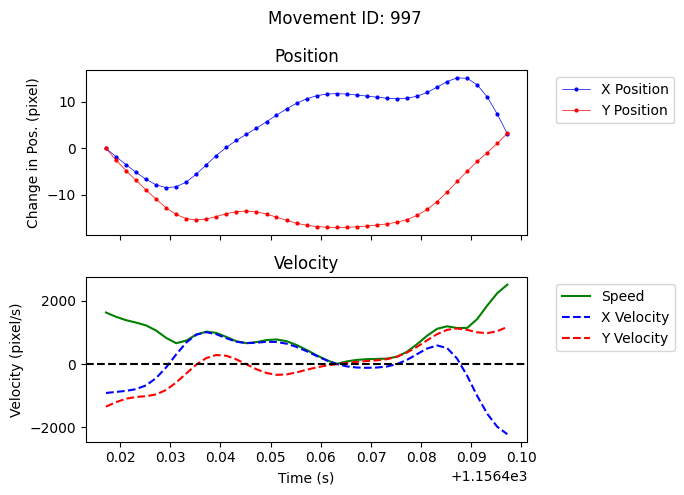

In [23]:
all_movement_ids = tongue_segmented['movement_id'].unique()
movement_ids = np.random.choice(all_movement_ids, size=3, replace=False)
plot_basic_kinematics_movement_segment(tongue_segmented, movement_ids=movement_ids.tolist())




In [13]:
# import importlib
# import aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils as tku

# importlib.reload(tku)

# from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import plot_basic_kinematics_movement_segment


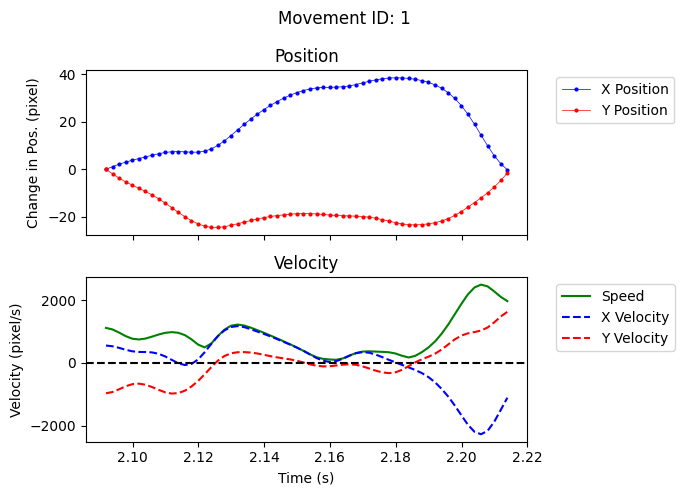

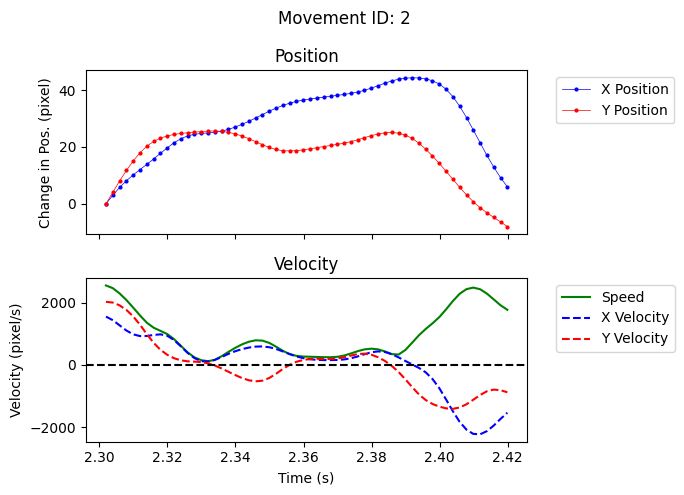

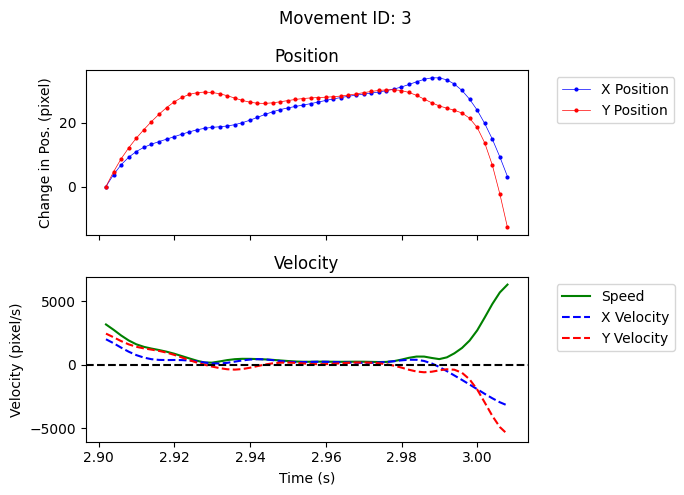

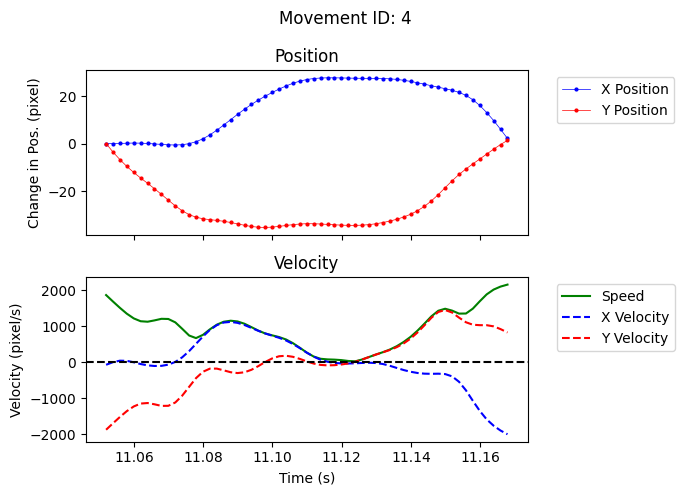

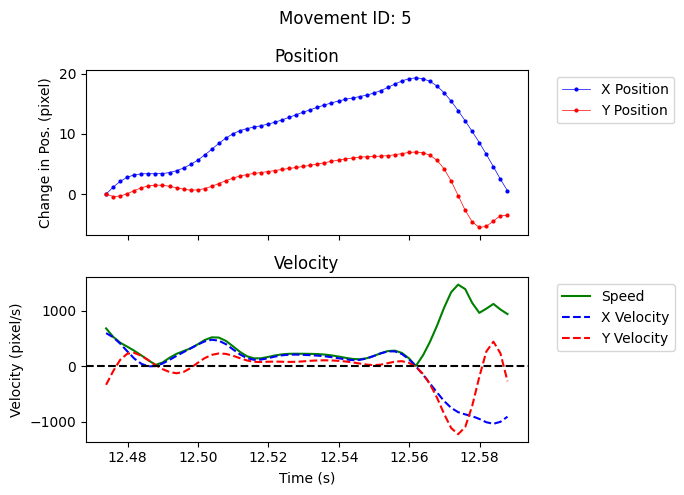

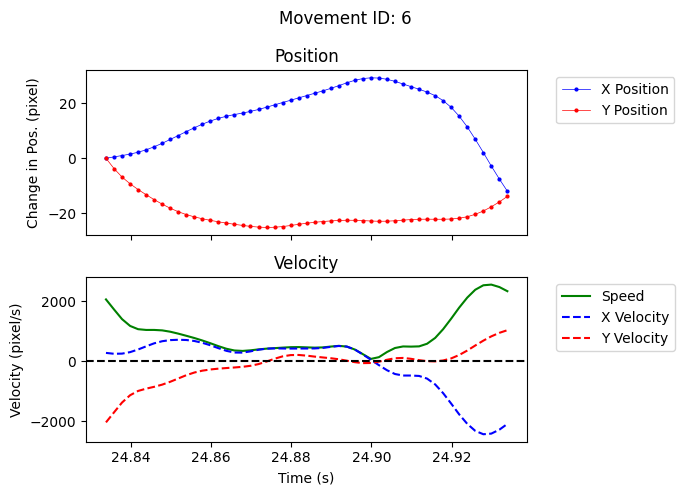

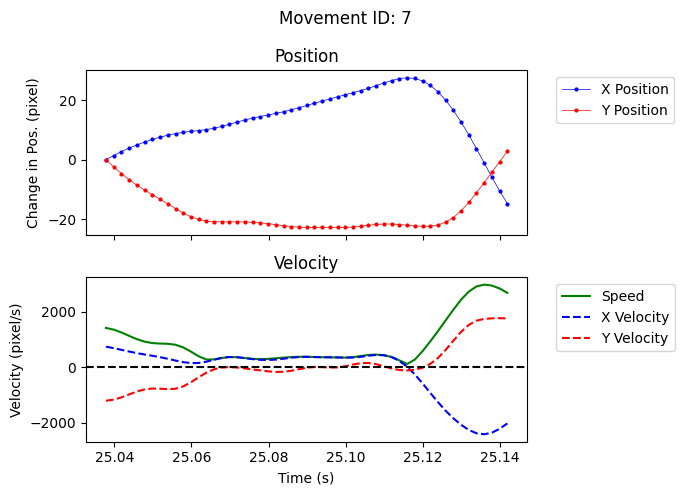

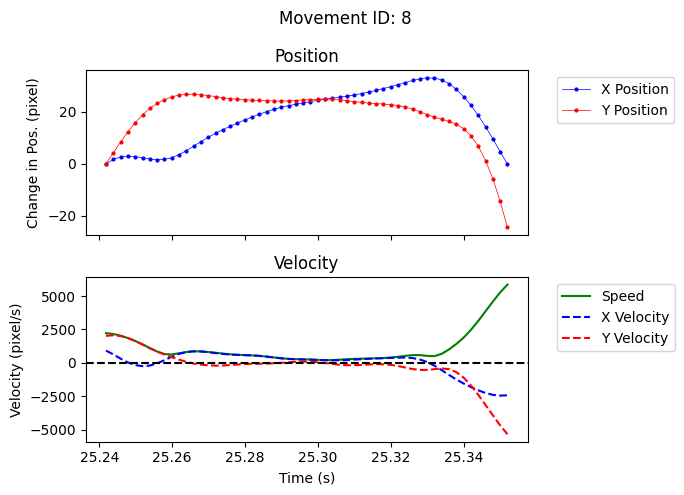

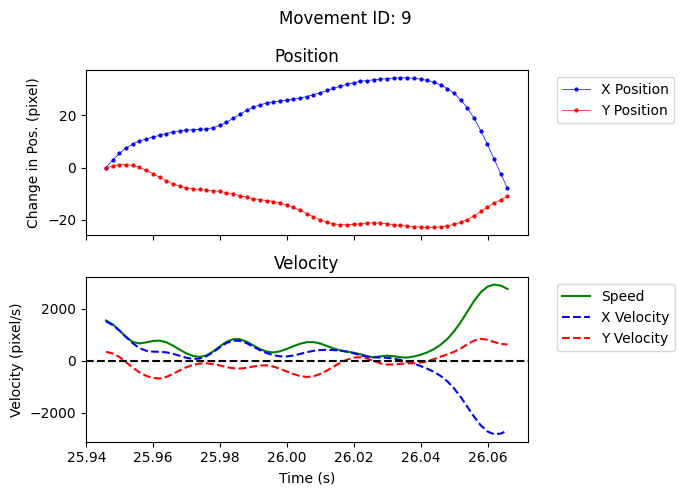

In [7]:
plot_basic_kinematics_movement_segment(tongue_segmented,movement_ids=list(range(1,10)))
